In [114]:
from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
import numpy as np
import nltk
import re
nltk.download('punkt')
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem.snowball import SnowballStemmer
from unidecode import unidecode
import matplotlib.pyplot as plt
from scipy.sparse.linalg import svds
from scipy.linalg import svd


with open('data.txt', 'r') as file:
    # Read the entire contents of the file
    content = file.read()

# Split the content into sentences using punctuation + newline as separators
sentences = re.split(r'[.!?]\s*\n', content)

# Strip leading and trailing whitespaces from each sentence
array_of_sentences = [sentence.strip() for sentence in sentences if sentence.strip()]


for sent in array_of_sentences:
    print(sent)
    print("\n")

Page Ranking for a Web Search Engine


When a search is made on the Internet using a search engine, there is first a traditional text processing part, where the aim is to find all the Web pages containing the words of the query


Due to the massive size of the Web, the number of hits is likely to be much too large to be of use


Therefore, some measure of quality is needed to filter out pages that are assumed to be less interesting


When one uses a Web search engine it is typical that the search phrase is underspecified


A Google search conducted on September 29, 2005, using the search phrase university, gave as a result links to the following well-known universities: Harvard, Stanford, Cambridge, Yale, Cornell, Oxford


The total number of Web pages relevant to the search phrase was more than 2 billion


Clearly Google used an algorithm for ranking all the Web pages that agrees rather well with a common-sense quality measure


The ranking procedure was based not on human judgment bu

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Lycko\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Lycko\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [115]:
# document preprocessing

stop_words = set(stopwords.words('english')) # Does not contain same stop words as in the book, may effect result.
#stop_words.update(set(str(i) for i in range(10)))  # Add digits to the set of stop words
#print(stop_words)
# Add stopwords manually
#stop_words.extend(['2000', '11','2', '13', '4','5', '6', '17','8', '19']) #TODO fixa så nummer inte kmr med, se till a göra toString innan?
#print(stop_words)
#stop_words.extend(['matrix', 'eigenvalue','vector', 'eigenvector'])

stemmer = SnowballStemmer("english", ignore_stopwords=True)

# Store final preprocessed data set in 'corpus'
corpus = [] 

for sentence in array_of_sentences:

    # Remove non-alphabetic characters and numbers
    sentence = re.sub(r'[^a-zA-Z\s]', '', sentence)

    # Tokenize the sentence into words
    words = sentence.split()

    # Remove stopwords and apply stemming to each word
    processed_words = [stemmer.stem(word) for word in words if word.lower() not in stop_words]

    # Join the processed words to form the processed sentence
    processed_sentence = ' '.join(processed_words)

    # Append the processed sentence to the list
    corpus.append(processed_sentence)

# Convert the processed list to a NumPy array
array_corpus = np.array(corpus)

# 'array_corpus' is a NumPy array containing processed sentences
print(array_corpus.shape)

(173,)


In [116]:
# Initialize the TfidfVectorizer with appropriate options
vectorizer = TfidfVectorizer()

# Fit and transform the processed sentences to obtain the sparse TF-IDF matrix (This is our matrix A)
tfidf_matrix = vectorizer.fit_transform(array_corpus).T

print(tfidf_matrix.shape)

# Convert the TF-IDF matrix to a dense NumPy array (notcused)
dense_tfidf_matrix = tfidf_matrix.toarray()


(486, 173)


In [125]:


# perform SVD on the sparse matrix A (tfidf_matrix)
# k denotes the number of singular values and singular vectors to compute.
u, s, v = svd(dense_tfidf_matrix,full_matrices=False) 
#print(u)
#print(s)
#v = abs(v)

print(u.shape)
print(v.shape)

# Extract the most important sentences and terms
most_important_terms_indices = np.argsort(u[:, 0])[::-1][0 : 5] #[::-1] = reversing the list because argsort choose ascending order
most_important_sentences_indices = np.argsort(v[0, :])[::-1][0 : 5] #[::-1] = reversing the list because argsort choose ascending order

# Get the actual sentences and terms
most_important_sentences = [array_of_sentences[i] for i in most_important_sentences_indices]
most_important_terms = [vectorizer.get_feature_names_out()[i] for i in most_important_terms_indices]


print("\nTop k most important terms:")
for term in most_important_terms:
    print(term)
print("\n")
# Print the results
print("Top k most important sentences:")
for sentence in most_important_sentences:
    print(sentence)





(486, 173)
(173, 173)

Top k most important terms:
eigenvalu
matrix
page
eigenvector
vector


Top k most important sentences:
We compute the eigenvalues and eigenvectors of the matrix with from and
The column-stochastic matrix defined in is irreducible (since A > 0) and has the dominant eigenvalue. The corresponding eigenvector satisfies
Assume that the eigenvalues of the column-stochastic matrix are
In the following symbolic picture of the matrix Q, nonzero elements are denoted:

The following link graph illustrates a set of Web pages with outlinks and inlinks:

The corresponding matrix becomes
Since page 4 has no outlinks, the corresponding column is equal to zero
Then the eigenvalues of are


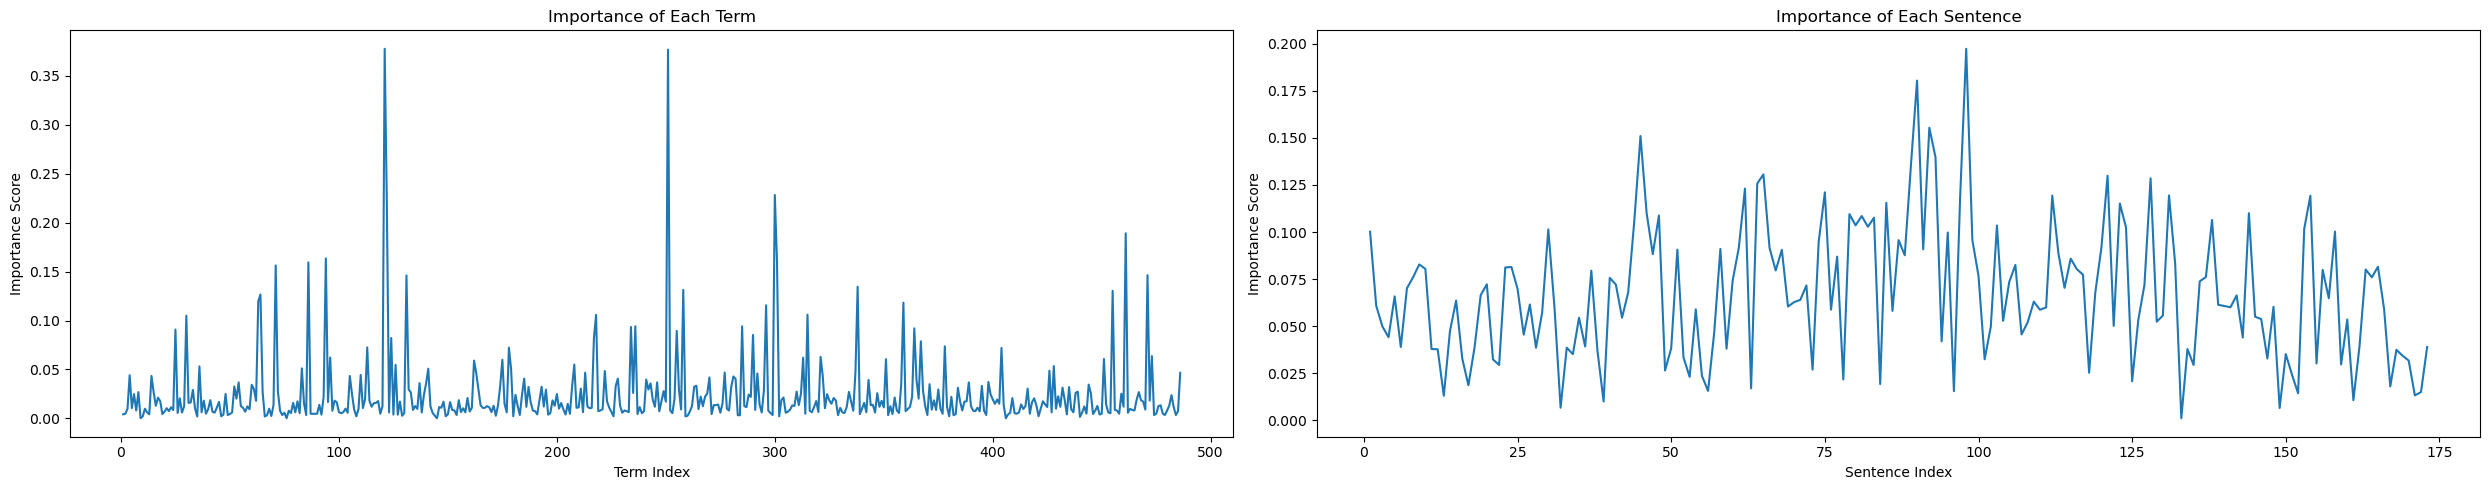

In [5]:


# Plot the importance of each term
plt.figure(figsize=(25, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(u[:, 0]) + 1), np.abs(u[:, 0]))
plt.title('Importance of Each Term')
plt.xlabel('Term Index')
plt.ylabel('Importance Score')

# Plot the importance of each sentence
plt.subplot(1, 2, 2)
plt.plot(range(1, len(v[0, :]) + 1), np.abs(v[0, :]))
plt.title('Importance of Each Sentence')
plt.xlabel('Sentence Index')
plt.ylabel('Importance Score')

plt.tight_layout()
plt.show()

In [184]:
#Rank k using QR decomposition with column pivoting
import numpy as np
from scipy.linalg import qr

k = 10

# Assuming D is your TF-IDF matrix
u, s, v = svd(dense_tfidf_matrix, full_matrices=False) #Returns with k = min(m,n)

u = u[:,k]
v = v[k,:]
s = s[:k]

#print(s.shape)
#print(v.shape)

D = (s[:,None]*v) 
print(D.shape)

# QR decomposition with column pivoting
Q, R, P = qr(D, mode='economic', pivoting=True)
#print(Q.shape)
#print(R.shape)
#print(P.shape)

# Compute the indices of the first k columns of AP
n = D.shape[1] #173 = correct

p = np.arange(1, n + 1) @ np.eye(n)[:, P].astype(int)
p = p[:,None]
print(p.shape)

pk = []
for index in p[:k]:
    pk.append(index[0])

print(pk)

print(array_of_sentences[123])


(10, 173)
(173, 1)
[36, 89, 80, 116, 38, 123, 61, 121, 104, 37]
Since in the pagerank computations we are dealing with a positive matrix, whose columns all add up to one, it is natural to use the 1-norm instead [65]
